In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Data Sources

https://ourworldindata.org/coronavirus-source-data <br>
https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures

# Other resources
https://www.jstor.org/stable/pdf/2983678.pdf?casa_token=ndhMP8_FyQcAAAAA:VdJ0dURQTcu13ymLQFa87zyAfCi4ga9JOkNwJbL1i0VRaPhFw1hwYoOIf0lSc7lg6_b8SUNCm4_uiF3wOJdhcuHYSzjGxtYa63z--GTmZbv-Ot0tE5g <br>
https://arxiv.org/pdf/0711.0189.pdf <br>
https://www.sciencedirect.com/science/article/pii/S1201971220303179#bib0010 <br>
reason for the decrease in august? https://eacea.ec.europa.eu/national-policies/eurydice/sites/eurydice/files/school_calendar_2020_21_0.pdf

In [2]:
EU = ['Belgium', 
      'Bulgaria', 
      'Denmark',
      'Germany',
      'Estonia',
      'Finland',
      'France',
      'Greece',
      'Ireland',
      'Italy',
      'Croatia',
      'Latvia',
      'Lithuania',
      'Luxembourg',
      'Malta',
      'Netherlands',
      'Austria',
      'Poland',
      'Portugal',
      'Romania',
      'Sweden',
      'Slovakia',
      'Slovenia',
      'Spain',
      'Czechia',
      'Hungary',
      'Cyprus']

In [3]:
df = pd.read_csv('owid-covid-data.csv')
df = df[df.location.isin(EU)]

In [4]:
data = df.pivot(index='date', columns='iso_code', values='new_cases').fillna(0)

In [5]:
data = np.sqrt(data).diff().dropna()

# Study of Network Connectedness

In [6]:
import networkx as nx

In [7]:
def average_clustering(dat, edge_thresh=0.5):
    W = ((dat.corr()-np.eye(len(dat.corr())))>edge_thresh).fillna(0)
    d = W.sum(axis=1)
    W_filtered = W[d>0][(d[d>0].index.tolist())]
    G = nx.from_numpy_array(W_filtered.to_numpy())
    clustering = nx.clustering(G)
    return np.mean(list(clustering.values()))

In [8]:
N = len(data)
window_size = 30

In [9]:
start_date, clustering = [], []
for start in range(0, N-window_size):
    dat = data.iloc[start:start+window_size]
    start_date.append(dat.index[-1])#dat.index[int(window_size/2)])
    clustering.append(average_clustering(dat))

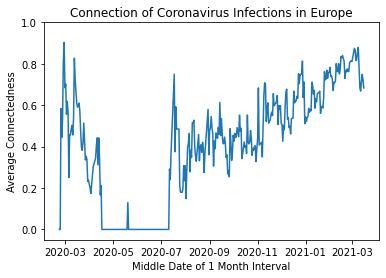

In [10]:
plt.plot([datetime.strptime(date, '%Y-%m-%d') for date in start_date], clustering)
plt.xlabel('Middle Date of 1 Month Interval')
plt.ylabel('Average Connectedness')
plt.title('Connection of Coronavirus Infections in Europe');
plt.ylim((-0.05,1))

clustering_unshrunk = clustering

In [11]:
import covariance_DRO

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def average_clustering_shrunk(dat, edge_thresh=0.5, method='Fisher-Rao', radius=1e-2):
    cov = dat.cov()
    cov_filtered = cov[cov.sum(axis=1)>0][(cov.sum(axis=1)[cov.sum(axis=1)>0].index.tolist())]
    cov_shrunk = np.real(covariance_DRO.estimate_cov(cov_filtered.to_numpy(), radius, method))
    if np.any(np.isnan(correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk)))):
        return np.nan
    W = correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk))>edge_thresh
    G = nx.from_numpy_array(W)
    clustering = nx.clustering(G)
    return np.mean(list(clustering.values()))

In [12]:
def connectedness(method='Fisher-Rao', radius=0.3, edge_thresh=0.5):
    start_date, clustering = [], []
    for start in range(0, N-window_size):
        dat = data.iloc[start:start+window_size]
        start_date.append(dat.index[-1])#dat.index[int(window_size/2)])
        clustering.append(average_clustering_shrunk(dat, radius=radius, method=method))
    return pd.DataFrame(data={
        'date': start_date,
        'connectedness': clustering
    })

In [13]:
def create_matrix(method, radii):
    results = np.zeros((len(radii), len(radii)))
    for i in range(len(radii)):
        df1 = connectedness(method=method, radius=radii[i])
        for j in range(i+1,len(radii)):
            df2 = connectedness(method=method, radius=radii[j])
            res = df1.join(df2.set_index('date'), on='date', lsuffix='_r0', rsuffix='_r1')
            d = ((res.connectedness_r0-res.connectedness_r1)**2).mean()
            results[i,j]= d
            results[j,i]= d
    return results

In [ ]:
res_fr = create_matrix('Fisher-Rao', np.logspace(-2, 2, num=50))
res_ws = create_matrix('Wasserstein', np.logspace(-2, 3, num=50))
res_kl = create_matrix('KLdirect', np.logspace(-2, 2, num=50))
# from joblib import Parallel, delayed
# import multiprocessing
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

# [res_fr, res_ws, res_kl] = Parallel(n_jobs=int(num_cores/2))\
#     (delayed(create_matrix)(name, range_) for name,range_ in zip(['Fisher-Rao','Wasserstein' ]) )

In [ ]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
max_col = np.max([res_fr.max(), res_ws.max(), res_kl.max()])
r1 = axs[0].matshow(res_fr, clim=[0,max_col])
r2 = axs[1].matshow(res_ws, clim=[0,max_col])
#r3 = axs[2].matshow(res_kl, clim=[0,max_col])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(r1, cax=cbar_ax)

In [ ]:
def linearMethod(emp_cov, epsilon):
    mu = np.trace(emp_cov) / emp_cov.shape[0]
    cov = (1.0 - epsilon) * emp_cov
    cov.flat[:: emp_cov.shape[0] + 1] += epsilon * mu
    return cov

def linearMethodDiagonal(emp_cov, epsilon):
    mu = np.diag(np.diag(emp_cov))
    cov = (1.0 - epsilon) * emp_cov + mu * epsilon
    return cov

def average_clustering_shrunk_linear(dat, edge_thresh=0.5, epsilon=0.1, diagonal=True):
    cov = dat.cov()
    cov_filtered = cov[cov.sum(axis=1)>0][(cov.sum(axis=1)[cov.sum(axis=1)>0].index.tolist())]
    if diagonal:
        cov_shrunk = linearMethodDiagonal(cov_filtered.to_numpy(), epsilon)
    else:
        cov_shrunk = linearMethod(cov_filtered.to_numpy(), epsilon)
    if np.any(np.isnan(correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk)))):
        return np.nan
    W = correlation_from_covariance(cov_shrunk)-np.eye(len(cov_shrunk))>edge_thresh
    G = nx.from_numpy_array(W)
    clustering = nx.clustering(G)
    return np.mean(list(clustering.values()))


In [ ]:
def connectedness_linear(diagonal=True, epsilon=0.3, edge_thresh=0.5):
    start_date, clustering = [], []
    for start in range(0, N-window_size):
        dat = data.iloc[start:start+window_size]
        start_date.append(dat.index[-1])#dat.index[int(window_size/2)])
        clustering.append(average_clustering_shrunk_linear(dat, epsilon=epsilon, diagonal=diagonal))
    return pd.DataFrame(data={
        'date': start_date,
        'connectedness': clustering})

In [ ]:
def create_matrix_linear(diagonal, radii):
    results = np.zeros((len(radii), len(radii)))
    for i in range(len(radii)):
        df1 = connectedness_linear(diagonal=diagonal, epsilon=radii[i])
        for j in range(i+1,len(radii)):
            df2 = connectedness_linear(diagonal=diagonal, epsilon=radii[j])
            res = df1.join(df2.set_index('date'), on='date', lsuffix='_r0', rsuffix='_r1')
            d = ((res.connectedness_r0-res.connectedness_r1)**2).mean()
            results[i,j]= d
            results[j,i]= d
    return results

In [ ]:
res_ld = create_matrix_linear(True, np.logspace(-4,0))
res_l = create_matrix_linear(False, np.logspace(-4,0))

In [ ]:
fig,axs = plt.subplots(2,3, figsize=(15,10))
max_col = np.max([res_fr.max(), res_ws.max(), res_kl.max(), res_ld.max(), res_l.max()])
r1 = axs[0][0].matshow(res_fr, clim=[0,max_col])
r2 = axs[0][1].matshow(res_ws, clim=[0,max_col])
r3 = axs[0][2].matshow(res_kl, clim=[0,max_col])
r4 = axs[1][0].matshow(res_ld, clim=[0,max_col])
r5 = axs[1][2].matshow(res_l, clim=[0,max_col])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
fig.colorbar(r4, cax=cbar_ax)

for i in range(3):
    axs[0][i].set_xticks(np.linspace(0, 50, num=5))
    axs[0][i].set_xticklabels(np.logspace(-2, 3, num=5) if i==3 else np.logspace(-2, 2, num=5))
    axs[0][i].set_yticks(np.linspace(0, 50, num=5))
    axs[0][i].set_yticklabels(np.logspace(-2, 3, num=5) if i==3 else np.logspace(-2, 2, num=5))
    
for i in range(3):
    if i==1:
        continue
    axs[1][i].set_xticks(np.linspace(0, 50, num=5))
    axs[1][i].set_xticklabels(np.logspace(-4, 0, num=5))
    axs[1][i].set_yticks(np.linspace(0, 50, num=5))
    axs[1][i].set_yticklabels(np.logspace(-4, 0, num=5))
    
axs[1][1].axis('off')
axs[0][0].set_title('Fisher-Rao')
axs[0][1].set_title('Wasserstein')
axs[0][2].set_title('Kullback-Leibler')
axs[1][0].set_title('Linear Diagonal')
axs[1][2].set_title('Linear')

plt.savefig('covid_sensitivity.pdf')